In [4]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2


In [5]:
import csv
import pandas as pd
import numpy as np
from packer import Packer
import matplotlib.pyplot as plt
from tqdm import tqdm


In [6]:
df = pd.read_csv('dataset.csv', sep=',')
print(df.head(22))

    Order_ID  Product_ID  Quantity   L   W
0          1           0         5  29  19
1          1           1         5  29  19
2          1           2        10  29  19
3          1           3         4  29  19
4          1           4         6  29  19
5          1           5        10  29  19
6          1           6         2  39  26
7          1           7         2  39  26
8          1           8         2  46  15
9          1           9         2  46  15
10         1          10         1  40  26
11         1          11         1  40  26
12         1          12         2  40  26
13         1          13         2  40  26
14         1          14         1  40  26
15         1          15         1  40  26
16         1          16         1  32  21
17         1          17         1  32  21
18         1          18         1  32  21
19         1          19         1  32  21
20         2           0         4  39  26
21         2           1         2  39  26


In [52]:
results = []
for order_id, order in tqdm(df.groupby("Order_ID")):
    packer = Packer(order)

    packer.pack()

    liquid_filling = (order["Quantity"] * order["L"] * order["W"]).sum() / (100*120)
    amount_of_layers = len(packer.packed_items.layers)
    results.append([order_id, liquid_filling, amount_of_layers])

results_df = pd.DataFrame(results, columns=["Order_ID", "Liquid_Filling", "Amount_of_Layers"])
print(results_df["Amount_of_Layers"].sum())



100%|██████████| 2361/2361 [00:07<00:00, 312.31it/s]

10630


      Order_ID  Liquid_Filling  Amount_of_Layers     Error
6            7        7.966250                10  2.033750
1678      1777        7.993417                10  2.006583
1333      1410        6.084000                 8  1.916000
964       1015        5.133750                 7  1.866250
1942      2053        4.145167                 6  1.854833
2292      2421        8.150000                10  1.850000
2094      2213        6.157333                 8  1.842667
1079      1137        6.179917                 8  1.820083
68          71        6.179917                 8  1.820083
1195      1260        6.191917                 8  1.808083
10630
2173.69175


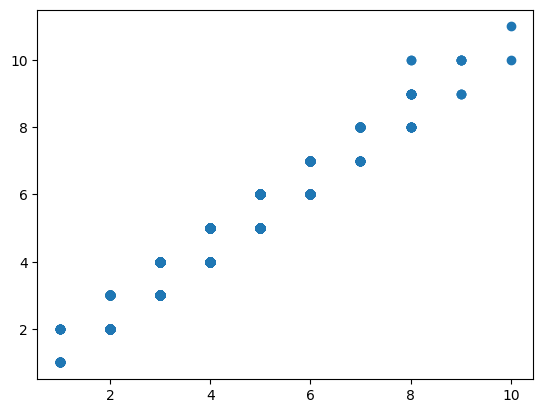

In [53]:
results_df["Error"] = results_df["Amount_of_Layers"] - results_df["Liquid_Filling"]
results_df.sort_values(by=["Error"], ascending=False, inplace=True)
print(results_df.head(10))
print(results_df["Amount_of_Layers"].sum())
print(results_df["Error"].sum())
plt.scatter(np.ceil(results_df["Liquid_Filling"]), results_df["Amount_of_Layers"])
plt.show()


In [54]:
# interesting_orders = [1,2151,2421,306,1188]
interesting_orders = [7]

Order ID:  7
Amount of layers:  10
Liquid filling:  7.96625


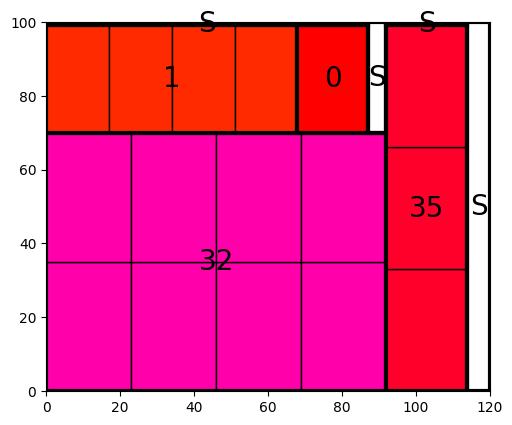

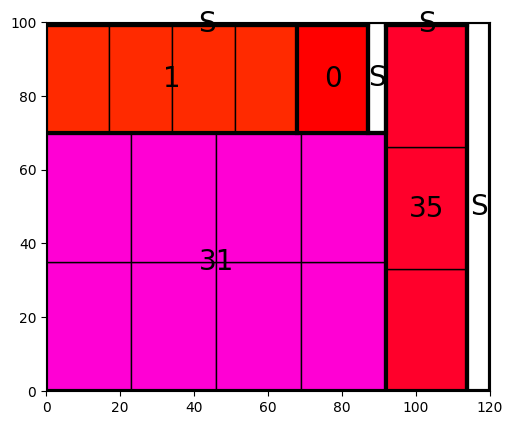

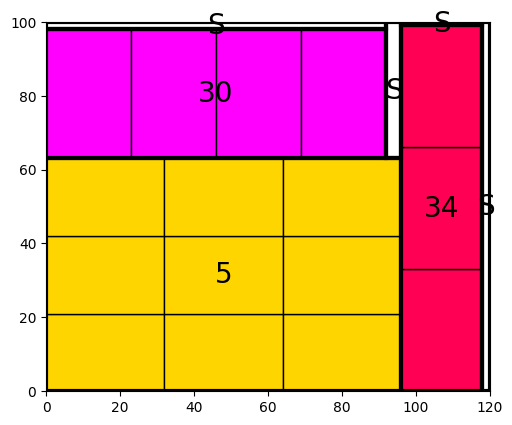

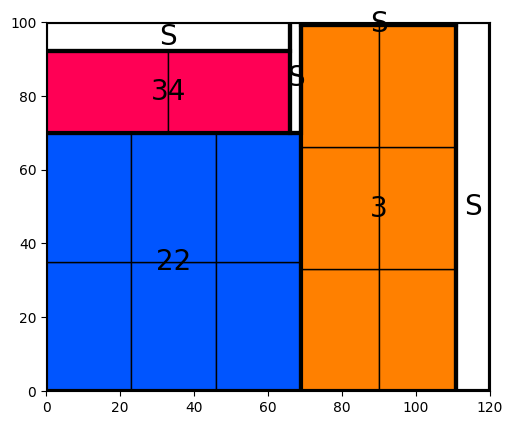

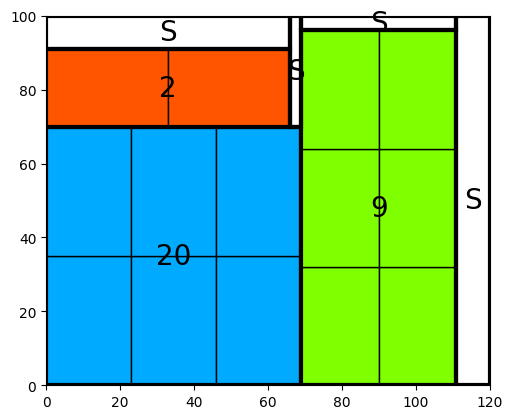

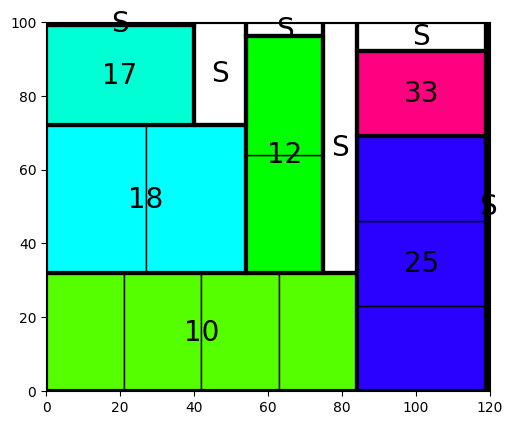

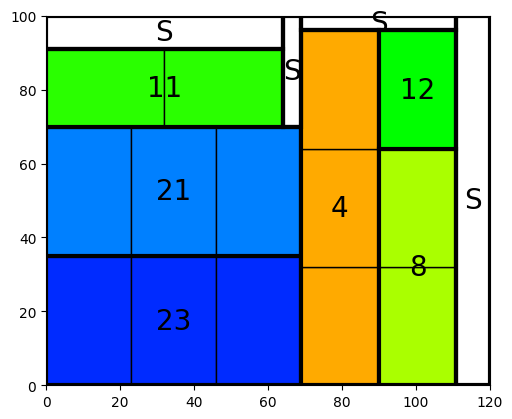

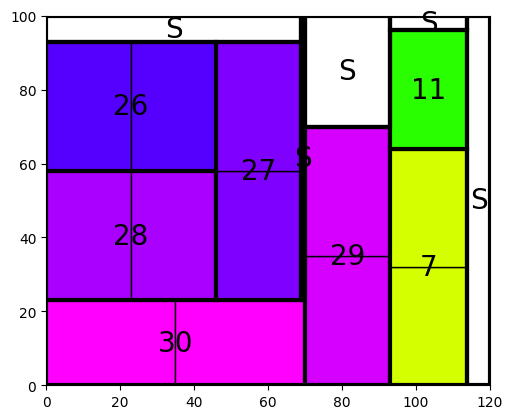

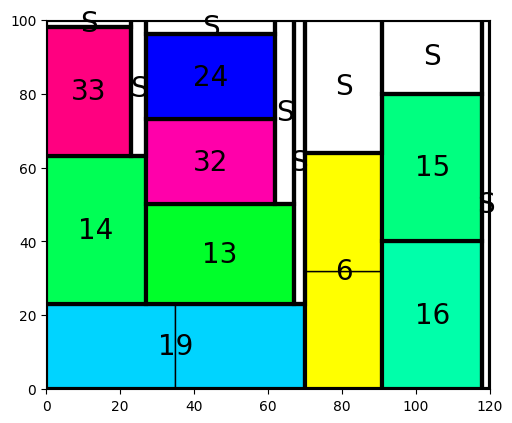

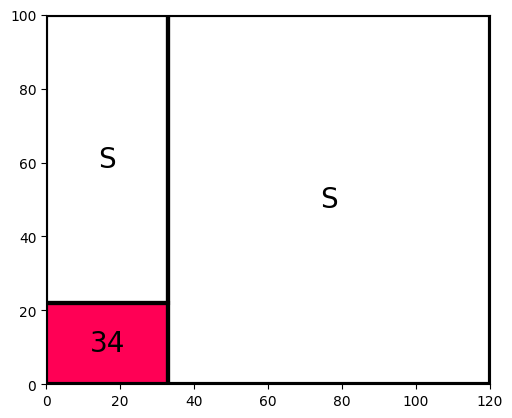

In [70]:
order_ids = interesting_orders

for order_id in order_ids:
    order = df[df["Order_ID"] == order_id]
    print("Order ID: ", order_id)
    liquid_filling = (order["Quantity"] * order["L"] * order["W"]).sum() / (100*120)
    packer = Packer(order)
    packer.pack()

    print("Amount of layers: ", len(packer.packed_items.layers))
    print("Liquid filling: ", liquid_filling)
    packer.visualise()

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.00833333 0.00833333 0.00833333 ... 0.00833333 0.00833333 0.00833333]
 [0.01666667 0.01666667 0.01666667 ... 0.01666667 0.01666667 0.01666667]
 ...
 [0.95       0.95       0.95       ... 0.95       0.95       0.95      ]
 [0.975      0.975      0.975      ... 0.975      0.975      0.975     ]
 [1.         1.         1.         ... 1.         1.         1.        ]]
1.0


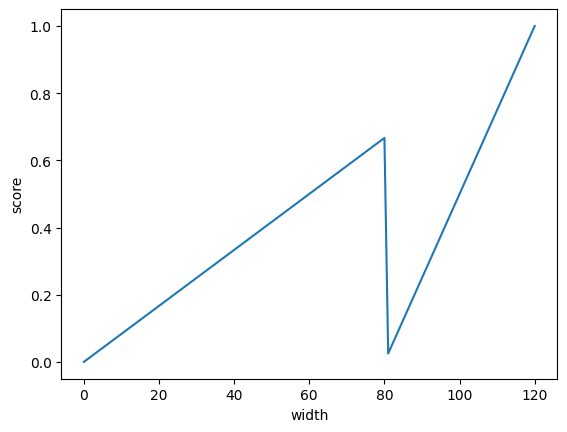

In [71]:
space_width = 120
space_height = 100

shapes = np.array([[40,60],[50,50],[60,40]])

min_fits = np.zeros(space_width+1)
min_fits.fill(space_height+1)
for i in range(space_width):
    idx = np.where(shapes[:,0] <= i)[0]
    if len(idx) == 0:
        continue
    min_fits[i] = np.min(shapes[idx,1])


scores = np.zeros((space_width+1, space_height+1))

for x in range(space_width+1):
    for y in range(space_height+1):
        # space1_w = shape_width - x; space1_h = shape_height; space2_w = x; space2_h = shape_height - y

        min_width = np.min(shapes[:,0])
        min_height = np.min(shapes[:,1])

        width_cutoff = space_width - min_width
        height_cutoff = space_height - min_height

        score1_w = (x / space_width) * (x <= width_cutoff)
        score1_h = (y / space_height) * (y <= height_cutoff)

        # score2_w = (((x - width_cutoff) / (space_width - width_cutoff))) * (x > width_cutoff)
        # score2_h = (((y - height_cutoff) / (space_height - height_cutoff))) * (y > height_cutoff)

        # p = 4
        # score2_w = 1/(min_width**p) * (x - width_cutoff)**p * (x > width_cutoff)
        # score2_h = 1/(min_height**p) * (y - height_cutoff)**p * (y > height_cutoff)

        a = 0

        score2_w = ((1 - a*width_cutoff/space_width)/min_width * x + (width_cutoff * (a - 1))/min_width) * (x > width_cutoff)
        score2_h = ((1 - a*height_cutoff/space_height)/min_height * y + (height_cutoff * (a - 1))/min_height) * (y > height_cutoff)


        width_score = score1_w + score2_w
        height_score = score1_h + score2_h
        scores[x,y] = width_score

print(scores)
print(np.max(scores))
# plt.imshow(scores)
# plt.ylabel("height")
# plt.xlabel("width")

ax = plt.plot(scores[:,0])
plt.ylabel("score")
plt.xlabel("width")


plt.show()

In [72]:
class Shape():
    __slots__ = ['w', 'h', 'q', 'item_id', 'item_width', 'item_height']

    def __init__(self,w,h,q,item_id,item_width,item_height):
        self.w = w
        self.h = h
        self.q = q
        self.item_id = item_id
        self.item_width = item_width
        self.item_height = item_height

    def __repr__(self):
        return "({}, {}, {}, {})".format(self.w,self.h,self.q,self.item_id)
        
class OpenSpace():
    __slots__ = ['x','y','w','h','layer','corners']

    def __init__(self, x, y, w, h, layer):
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        self.layer = layer
        self.corners = [(x,y),(x+w,y),(x,y+h),(x+w,y+h)]

    def __repr__(self):
        return "({}, {}, {}, {}, layer: {})".format(self.x,self.y,self.w,self.h,self.layer)
    
    def is_valid(self):
        return self.w > 0 and self.h > 0

In [67]:
from spaces import OpenSpaces
spaces = OpenSpaces(1)
shape = Shape(40,20,1,0,40,20)
space = OpenSpace(40,40,40,20,0)
spaces.add_space(space) 
spaces.split_space(shape,1)
print(spaces)

40 40 (40, 20, 1, 0) (0, 0, 120, 100, layer: 0) 40 40 40 20
[(0, 0, 120, 100, layer: 0), (0, 0, 40, 100, layer: 0), (0, 0, 120, 40, layer: 0), (0, 60, 120, 40, layer: 0), (80, 0, 40, 100, layer: 0)]


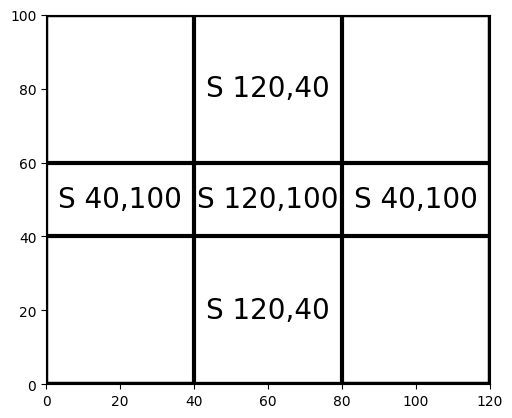

In [74]:
from matplotlib.patches import Rectangle
from consts import *
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
plt.axis([0,BIN_WIDTH,0,BIN_HEIGHT])
for space in spaces.open_spaces:
    if space.layer == 0:
        ax.add_patch(
            Rectangle(
                (space.x, space.y),  # (x,y)
                space.w,          # width
                space.h,          # height
                facecolor="white",
                edgecolor="black",
                linewidth=3,
                fill = False,
            )
        )
        ax.text(space.x+space.w/2, space.y+space.h/2, f"S {space.w},{space.h}", ha='center', va='center', fontsize=20)   